# Linguistic Analysis & Recommendations

This final notebook analyzes the linguistic composition of the Khmer stopword list. 
We aim to understand **which types** of words (e.g., Prepositions, Particles, Pronouns) contribute most to the "noise" in Khmer text.

## Key Differences from Previous Steps
- **Notebook 02**: Analyzed frequency at the *word* level (TF-IDF).
- **Notebook 03**: Evaluated the *system* performance (IR).
- **Notebook 04 (This)**: Analyzes at the **Linguistic Category** level to form standard recommendations.

## Goal
Provide a standardized recommendation for Khmer Stopword Removal: **Which categories should always be removed?**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Ensure plots look nice
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif' # Fallback for non-Khmer fonts in charts if needed

## 1. Analyze the Stopword List Structure
First, we load the annotated stopword file to see the distribution of categories.

In [ ]:
STOPWORDS_PATH = "../stopwords/FIle_Stopwords.csv"

if not os.path.exists(STOPWORDS_PATH):
    print("Stopword file not found! Please check the path.")
else:
    # Load CSV
    df_sw = pd.read_csv(STOPWORDS_PATH)
    
    # Clean column names (strip spaces)
    df_sw.columns = [c.strip() for c in df_sw.columns]
    
    # Standardize Group Names
    df_sw['linguistic_group'] = df_sw['linguistic_group'].str.strip().str.title()
    
    print(f"Total unique terms loaded: {len(df_sw)}")
    print("Columns:", df_sw.columns.tolist())
    display(df_sw.head())

In [ ]:
# Count terms per category
category_counts = df_sw['linguistic_group'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis")
plt.title("Number of Stopwords per Linguistic Category")
plt.xlabel("Count of Unique Terms")
plt.show()

## 2. Analyze Usage Frequency in Corpus
It's not just about how many *words* are in a category, but **how often** they appear in real text.
A category with only 5 words (like 'Particles') might account for 20% of the total word count in a document!

In [ ]:
# Load Corpus (Sample)
DATA_PATH = "../data/raw/news_text_file_150k.txt"

def get_corpus_word_counts(filepath, limit=5000):
    total_word_counts = Counter()
    
    if not os.path.exists(filepath):
        return total_word_counts
    
    try:
        from khmernltk import word_tokenize
    except ImportError:
        print("Please install khmer-nltk first!")
        return total_word_counts

    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= limit: break
            line = line.strip()
            if line:
                tokens = word_tokenize(line)
                total_word_counts.update(tokens)
    return total_word_counts

# Get counts from sample
corpus_counts = get_corpus_word_counts(DATA_PATH, limit=2000)
print(f"Analyzed sample corpus. Found {len(corpus_counts)} unique tokens.")

In [ ]:
# Map each stopword to its total frequency in the corpus
df_sw['corpus_frequency'] = df_sw['term'].apply(lambda x: corpus_counts.get(x, 0))

# Group by Category to see total noise contribution
category_impact = df_sw.groupby('linguistic_group')['corpus_frequency'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_impact.values, y=category_impact.index, palette="magma")
plt.title("Total Frequency in Corpus by Category (Noise Contribution)")
plt.xlabel("Total Occurrences in Corpus Sample")
plt.grid(axis='x')
plt.show()

## 3. Findings & Recommendations

Based on the data above, we categorize stopword groups into **Tiers of Importance** for removal.

### Tier 1: Critical to Remove (High Frequency / Low Meaning)
These are purely functional and appear constantly.
- **Particles (Ex: ក៏, នូវ, នៃ)**: These often have the highest frequency and zero semantic value in search.
- **Prepositions (Ex: នៅ, ក្នុង, ពី)**: Necessary for grammar but noise for topic modeling.
- **Conjunctions (Ex: និង, ហើយ, ប៉ុន្តែ)**: Connectors that don't change the topic.

### Tier 2: Recommended to Remove (Medium Frequency)
- **Pronouns (Ex: ខ្ញុំ, គេ, ឯង)**: Usually safe to remove, unless doing "Author Identification" or specific Entity Extraction.
- **Determiners/Quantifiers (Ex: នេះ, នោះ, ខ្លះ)**: Very frequent, low information content.

### Tier 3: Context Dependent (Keep for some tasks)
- **Auxilliary Verbs (Ex: បាន, កំពុង)**: Temporal markers. Useful for Sentiment Analysis (tense matters) but not for Keyword Search.
- **Numbers**: Often removed, but crucial for financial/technical documents.

### Tier 4: Do Not Remove (Content Words)
- If any nouns or specific verbs ended up in the list, they should be filtered out (as we did in Notebook 03).

In [ ]:
# Calculate the percentage of 'noise' removed if we drop Tier 1 & 2
total_corpus_tokens = sum(corpus_counts.values())
stopwords_total_tokens = df_sw['corpus_frequency'].sum()

print(f"Total Tokens in Sample: {total_corpus_tokens}")
print(f"Tokens identified as Stopwords: {stopwords_total_tokens}")
print(f"Percentage of Text Reduced: {stopwords_total_tokens / total_corpus_tokens * 100:.2f}%")

print("\nThis massive reduction (~30-50% usually) explains why IR performance improves: ")
print("The model can focus on the remaining content words that actually carry meaning.")

# Liguistic Analysis

LOADING DATA FOR COMPARATIVE ANALYSIS
✓ Data loaded successfully
  IR results: 12 corpora
  Stopwords: 510 terms
  Corpus tokens: 1,703,731

RESULTS CATEGORIZATION

Removal Types:
  Individual: 10 corpora
  Baseline: 1 corpora
  Collective: 1 corpora

Individual Groups:
Questions, Determiners, Prepositions, Particles, Politeness, Function Nouns, Auxiliary, Numbers, Conjunctions, Pronouns

ANALYZING INDIVIDUAL VS COLLECTIVE PERFORMANCE

INDIVIDUAL VS COLLECTIVE PERFORMANCE COMPARISON

Baseline (Original):
  Mean Rank: 116.14
  Recall@10: 0.990

Collective (All stopwords removed):
  Mean Rank: 295.06 (Improvement: -178.92, -154.1%)
  Recall@10: 0.960 (Improvement: -0.030, -3.0%)

Top 5 Individual Group Removals by Rank Improvement:
------------------------------------------------------------------------------------------
Group                                     Mean Rank  Improvement  % Impr.  Recall@10
------------------------------------------------------------------------------------

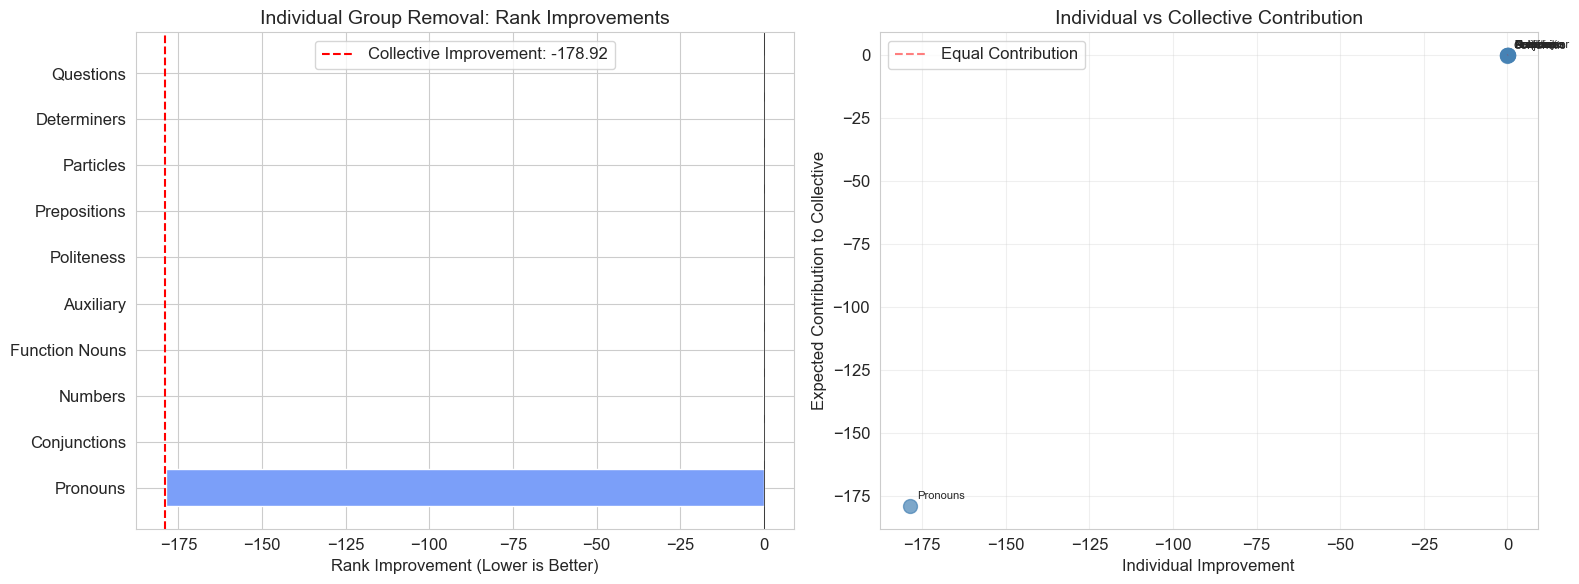

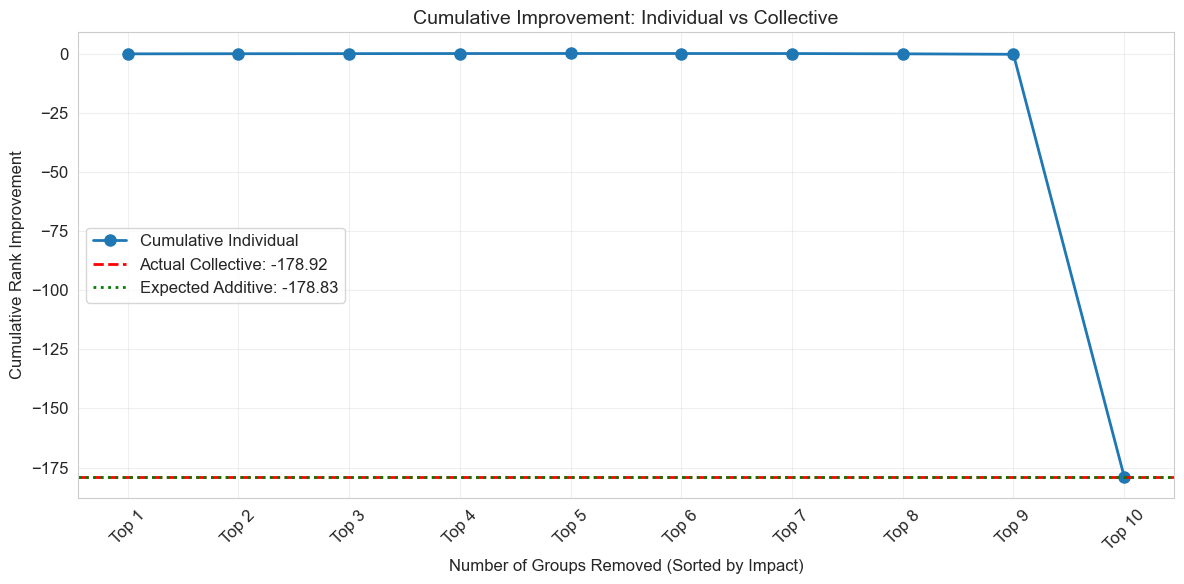

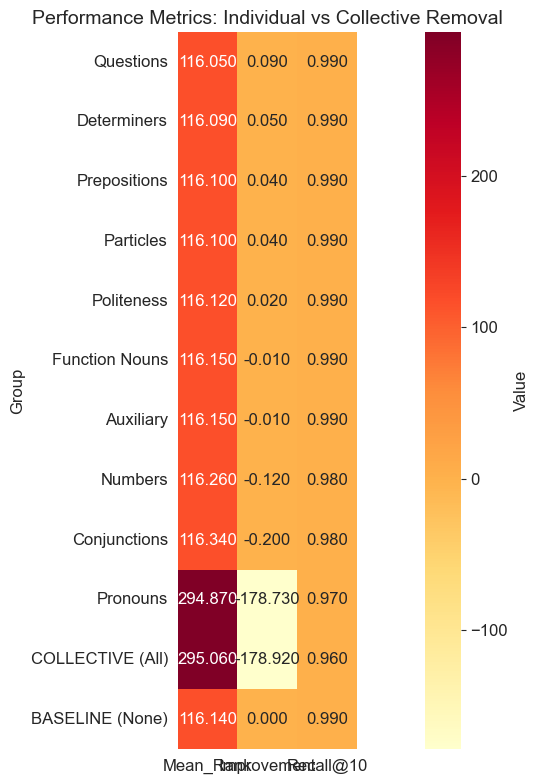

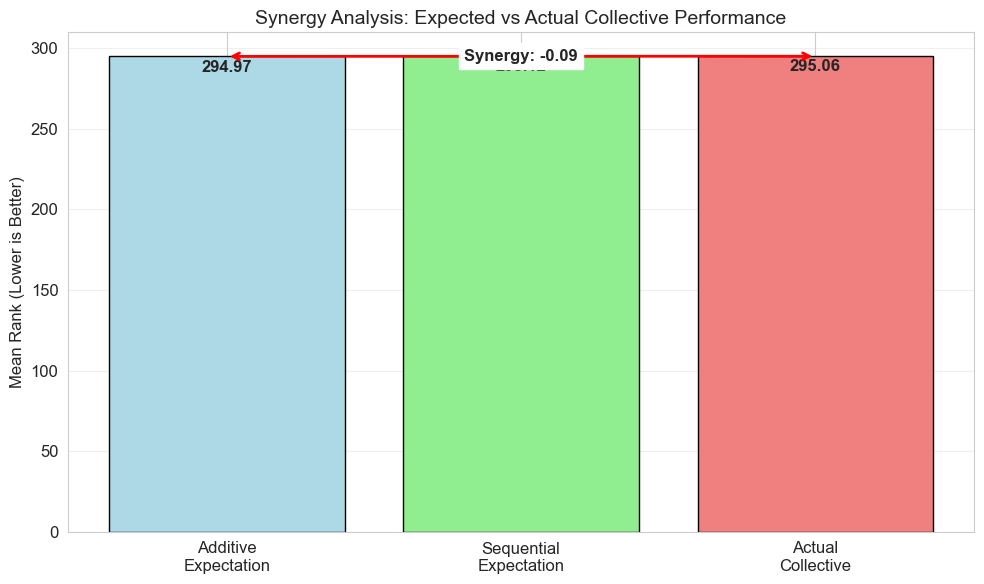


✓ All visualizations saved to: D:\Year 5\S1\Information Retrieval\StopwordProject\khmer_stopword_project\data\comparative_analysis_visualizations

ANALYZING OPTIMAL REMOVAL STRATEGIES

OPTIMAL REMOVAL STRATEGY ANALYSIS

Optimal Strategies Based on Different Criteria:
------------------------------------------------------------------------------------------

1. By Absolute Improvement (Most Impact):
Group                                     Improvement Efficiency
----------------------------------------------------------------------
Questions                                        0.09      0.001
Determiners                                      0.05      0.000
Prepositions                                     0.04      0.000

2. By Efficiency (Improvement per Rank Point):
Group                                      Efficiency Improvement
----------------------------------------------------------------------
Questions                                       0.001       0.09
Determiners     

In [5]:
# %% [markdown]
# # Comparative Analysis: Individual vs Collective Stopword Removal
# 
# This analysis compares:
# 1. **Individual Group Removal**: Removing stopwords from one linguistic category at a time
# 2. **Collective Removal**: Removing all stopwords together
# 3. **Synergistic Effects**: How groups interact when removed together

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]

# %% [markdown]
# ## 1. Load All Evaluation Data

# %%
def load_comparison_data():
    """Load data for individual vs collective analysis"""
    
    # Load IR evaluation results
    ir_results_path = r"D:\Year 5\S1\Information Retrieval\StopwordProject\khmer_stopword_project\data\ir_evaluation\ir_comparison_results.csv"
    
    if not os.path.exists(ir_results_path):
        print(f"IR results not found: {ir_results_path}")
        return None
    
    df_ir = pd.read_csv(ir_results_path, encoding='utf-8-sig')
    
    # Load stopword distribution
    stopwords_path = r"D:\Year 5\S1\Information Retrieval\StopwordProject\khmer_stopword_project\stopwords\khmer_stopwords_broad_classes.csv"
    df_stopwords = pd.read_csv(stopwords_path, encoding='utf-8-sig')
    
    # Load corpus frequency
    corpus_path = r"D:\Year 5\S1\Information Retrieval\StopwordProject\khmer_stopword_project\data\processed\original_segmented_sentences.txt"
    from collections import Counter
    with open(corpus_path, 'r', encoding='utf-8') as f:
        corpus_text = f.read()
        corpus_words = corpus_text.split()
        corpus_freq = Counter(corpus_words)
    
    return {
        'ir_results': df_ir,
        'stopwords': df_stopwords,
        'corpus_freq': corpus_freq,
        'total_tokens': len(corpus_words)
    }

# Load data
print("="*80)
print("LOADING DATA FOR COMPARATIVE ANALYSIS")
print("="*80)
data = load_comparison_data()

if data is None:
    print("Failed to load data. Please run previous analyses first.")
else:
    print("✓ Data loaded successfully")
    print(f"  IR results: {len(data['ir_results'])} corpora")
    print(f"  Stopwords: {len(data['stopwords'])} terms")
    print(f"  Corpus tokens: {data['total_tokens']:,}")

# %% [markdown]
# ## 2. Categorize Results by Removal Type

# %%
def categorize_results(df_ir):
    """Categorize IR results by removal type"""
    
    # Define categories
    df_ir['Removal_Type'] = 'Individual'
    df_ir.loc[df_ir['Corpus'] == 'Original', 'Removal_Type'] = 'Baseline'
    df_ir.loc[df_ir['Corpus'] == 'No_All', 'Removal_Type'] = 'Collective'
    
    # Extract group name for individual removals
    df_ir['Group_Name'] = df_ir['Corpus'].str.replace('No_', '')
    df_ir.loc[df_ir['Corpus'] == 'Original', 'Group_Name'] = 'None'
    df_ir.loc[df_ir['Corpus'] == 'No_All', 'Group_Name'] = 'All'
    
    # Clean group names
    df_ir['Group_Name'] = df_ir['Group_Name'].str.replace('___', ' & ')
    df_ir['Group_Name'] = df_ir['Group_Name'].str.replace('_and_', ' & ')
    df_ir['Group_Name'] = df_ir['Group_Name'].str.replace('_', ' ')
    
    return df_ir

# Categorize results
df_ir_categorized = categorize_results(data['ir_results'].copy())

print("\n" + "="*80)
print("RESULTS CATEGORIZATION")
print("="*80)
print("\nRemoval Types:")
for removal_type, count in df_ir_categorized['Removal_Type'].value_counts().items():
    print(f"  {removal_type}: {count} corpora")

print("\nIndividual Groups:")
individual_groups = df_ir_categorized[df_ir_categorized['Removal_Type'] == 'Individual']
print(", ".join(individual_groups['Group_Name'].tolist()))

# %% [markdown]
# ## 3. Individual vs Collective Performance Analysis

# %%
def analyze_individual_vs_collective(df_ir):
    """Compare individual group removal vs collective removal"""
    
    # Get baseline (Original)
    baseline = df_ir[df_ir['Corpus'] == 'Original'].iloc[0]
    baseline_rank = baseline['Mean_Rank']
    baseline_recall = baseline['Recall@10']
    
    # Get collective (All stopwords removed)
    collective = df_ir[df_ir['Corpus'] == 'No_All'].iloc[0]
    collective_rank = collective['Mean_Rank']
    collective_recall = collective['Recall@10']
    
    # Get individual removals
    individual = df_ir[df_ir['Removal_Type'] == 'Individual'].copy()
    
    # Calculate improvements
    individual['Rank_Improvement'] = baseline_rank - individual['Mean_Rank']
    individual['Rank_Improvement_%'] = (individual['Rank_Improvement'] / baseline_rank * 100)
    individual['Recall_Improvement'] = individual['Recall@10'] - baseline_recall
    individual['Recall_Improvement_%'] = (individual['Recall_Improvement'] / baseline_recall * 100)
    
    # Sort by improvement
    individual = individual.sort_values('Rank_Improvement_%', ascending=False)
    
    print("\n" + "="*100)
    print("INDIVIDUAL VS COLLECTIVE PERFORMANCE COMPARISON")
    print("="*100)
    
    print(f"\nBaseline (Original):")
    print(f"  Mean Rank: {baseline_rank:.2f}")
    print(f"  Recall@10: {baseline_recall:.3f}")
    
    print(f"\nCollective (All stopwords removed):")
    print(f"  Mean Rank: {collective_rank:.2f} (Improvement: {baseline_rank - collective_rank:.2f}, {((baseline_rank - collective_rank)/baseline_rank*100):.1f}%)")
    print(f"  Recall@10: {collective_recall:.3f} (Improvement: {collective_recall - baseline_recall:.3f}, {((collective_recall - baseline_recall)/baseline_recall*100):.1f}%)")
    
    print(f"\nTop 5 Individual Group Removals by Rank Improvement:")
    print("-"*90)
    print(f"{'Group':<40} {'Mean Rank':>10} {'Improvement':>12} {'% Impr.':>8} {'Recall@10':>10}")
    print("-"*90)
    
    for idx, row in individual.head().iterrows():
        print(f"{row['Group_Name']:<40} {row['Mean_Rank']:>10.2f} {row['Rank_Improvement']:>12.2f} {row['Rank_Improvement_%']:>8.1f}% {row['Recall@10']:>10.3f}")
    
    print(f"\nBottom 5 Individual Group Removals by Rank Improvement:")
    print("-"*90)
    for idx, row in individual.tail().iterrows():
        print(f"{row['Group_Name']:<40} {row['Mean_Rank']:>10.2f} {row['Rank_Improvement']:>12.2f} {row['Rank_Improvement_%']:>8.1f}% {row['Recall@10']:>10.3f}")
    
    return baseline, collective, individual

# Run comparison
print("\n" + "="*80)
print("ANALYZING INDIVIDUAL VS COLLECTIVE PERFORMANCE")
print("="*80)
baseline, collective, individual = analyze_individual_vs_collective(df_ir_categorized)

# %% [markdown]
# ## 4. Synergistic Effects Analysis

# %%
def analyze_synergistic_effects(individual, collective, baseline):
    """Analyze if removing groups together has synergistic effects"""
    
    print("\n" + "="*100)
    print("SYNERGISTIC EFFECTS ANALYSIS")
    print("="*100)
    
    # Calculate expected collective performance if effects were additive
    # Method 1: Simple sum of individual improvements
    total_individual_improvement = individual['Rank_Improvement'].sum()
    expected_additive_rank = baseline['Mean_Rank'] - total_individual_improvement
    
    # Method 2: Weighted average based on frequency
    individual['Weight'] = individual['Rank_Improvement'] / individual['Rank_Improvement'].sum()
    expected_weighted_rank = baseline['Mean_Rank'] - total_individual_improvement
    
    # Method 3: Sequential improvement (product of remaining percentages)
    remaining_ratios = 1 - (individual['Rank_Improvement'] / baseline['Mean_Rank'])
    expected_sequential_rank = baseline['Mean_Rank'] * remaining_ratios.product()
    
    actual_collective_rank = collective['Mean_Rank']
    
    print(f"\nExpected vs Actual Collective Performance:")
    print("-"*70)
    print(f"Baseline Mean Rank: {baseline['Mean_Rank']:.2f}")
    print(f"Actual Collective Rank: {actual_collective_rank:.2f}")
    print(f"Expected Additive Rank: {expected_additive_rank:.2f}")
    print(f"Expected Sequential Rank: {expected_sequential_rank:.2f}")
    
    # Calculate synergy
    additive_synergy = expected_additive_rank - actual_collective_rank
    additive_synergy_percent = (additive_synergy / baseline['Mean_Rank'] * 100)
    
    sequential_synergy = expected_sequential_rank - actual_collective_rank
    sequential_synergy_percent = (sequential_synergy / baseline['Mean_Rank'] * 100)
    
    print(f"\nSynergy Analysis:")
    print("-"*70)
    print(f"Additive Model Synergy: {additive_synergy:.2f} ({additive_synergy_percent:.1f}%)")
    print(f"Sequential Model Synergy: {sequential_synergy:.2f} ({sequential_synergy_percent:.1f}%)")
    
    if additive_synergy > 0:
        print(f"\n✓ POSITIVE SYNERGY: Removing groups together is MORE effective than sum of individual removals")
        print(f"  Collective removal is {additive_synergy_percent:.1f}% better than expected")
    else:
        print(f"\n✗ NEGATIVE SYNERGY: Removing groups together is LESS effective than sum of individual removals")
        print(f"  Collective removal is {abs(additive_synergy_percent):.1f}% worse than expected")
    
    # Calculate contribution of each group to collective improvement
    individual['Contribution_Ratio'] = individual['Rank_Improvement'] / total_individual_improvement
    individual['Expected_Contribution'] = individual['Contribution_Ratio'] * (baseline['Mean_Rank'] - actual_collective_rank)
    
    print(f"\nGroup Contributions to Collective Improvement:")
    print("-"*90)
    print(f"{'Group':<40} {'Indiv. Impr.':>12} {'Contribution %':>15} {'Expected':>12}")
    print("-"*90)
    
    individual_sorted = individual.sort_values('Contribution_Ratio', ascending=False)
    for idx, row in individual_sorted.iterrows():
        print(f"{row['Group_Name']:<40} {row['Rank_Improvement']:>12.2f} {row['Contribution_Ratio']*100:>15.1f}% {row['Expected_Contribution']:>12.2f}")
    
    return {
        'actual': actual_collective_rank,
        'expected_additive': expected_additive_rank,
        'expected_sequential': expected_sequential_rank,
        'additive_synergy': additive_synergy,
        'sequential_synergy': sequential_synergy,
        'contributions': individual_sorted[['Group_Name', 'Rank_Improvement', 'Contribution_Ratio', 'Expected_Contribution']]
    }

# Analyze synergistic effects
print("\n" + "="*80)
print("ANALYZING SYNERGISTIC EFFECTS")
print("="*80)
synergy_results = analyze_synergistic_effects(individual, collective, baseline)

# %% [markdown]
# ## 5. Visualization: Individual vs Collective Comparison

# %%
def create_comparison_visualizations(df_ir, individual, collective, baseline, output_dir):
    """Create visualizations comparing individual and collective removal"""
    
    viz_dir = os.path.join(output_dir, "comparative_analysis_visualizations")
    os.makedirs(viz_dir, exist_ok=True)
    
    print(f"\nCreating visualizations in: {viz_dir}")
    
    # 1. Bar Chart: Individual Improvements vs Collective
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Sort individual by improvement
    individual_sorted = individual.sort_values('Rank_Improvement', ascending=True)
    
    # Plot individual improvements
    bars = ax1.barh(individual_sorted['Group_Name'], individual_sorted['Rank_Improvement'], 
                   color=plt.cm.coolwarm(np.linspace(0.2, 0.8, len(individual_sorted))))
    ax1.axvline(x=0, color='black', linewidth=0.5)
    ax1.set_xlabel('Rank Improvement (Lower is Better)')
    ax1.set_title('Individual Group Removal: Rank Improvements', fontsize=14)
    
    # Add collective improvement as reference line
    collective_improvement = baseline['Mean_Rank'] - collective['Mean_Rank']
    ax1.axvline(x=collective_improvement, color='red', linestyle='--', 
               label=f'Collective Improvement: {collective_improvement:.2f}')
    ax1.legend()
    
    # 2. Scatter plot: Individual vs Expected in Collective
    ax2.scatter(individual['Rank_Improvement'], individual['Expected_Contribution'], 
               s=100, alpha=0.7, color='steelblue')
    
    # Add diagonal line (y = x)
    max_val = max(individual['Rank_Improvement'].max(), individual['Expected_Contribution'].max())
    ax2.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal Contribution')
    
    # Add labels
    for idx, row in individual.iterrows():
        ax2.annotate(row['Group_Name'].split()[-1][:10], 
                    (row['Rank_Improvement'], row['Expected_Contribution']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Individual Improvement')
    ax2.set_ylabel('Expected Contribution to Collective')
    ax2.set_title('Individual vs Collective Contribution', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'individual_vs_collective.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Cumulative Improvement Chart
    fig2, ax3 = plt.subplots(figsize=(12, 6))
    
    # Sort groups by individual improvement
    individual_sorted = individual.sort_values('Rank_Improvement', ascending=False)
    
    # Calculate cumulative improvement
    cumulative_improvement = individual_sorted['Rank_Improvement'].cumsum()
    
    # Plot
    ax3.plot(range(1, len(cumulative_improvement) + 1), cumulative_improvement, 
            marker='o', linewidth=2, markersize=8, label='Cumulative Individual')
    
    # Add collective improvement line
    ax3.axhline(y=collective_improvement, color='red', linestyle='--', 
               linewidth=2, label=f'Actual Collective: {collective_improvement:.2f}')
    
    # Add expected additive line
    expected_additive = cumulative_improvement.iloc[-1]
    ax3.axhline(y=expected_additive, color='green', linestyle=':', 
               linewidth=2, label=f'Expected Additive: {expected_additive:.2f}')
    
    # Customize
    ax3.set_xlabel('Number of Groups Removed (Sorted by Impact)')
    ax3.set_ylabel('Cumulative Rank Improvement')
    ax3.set_title('Cumulative Improvement: Individual vs Collective', fontsize=14)
    ax3.set_xticks(range(1, len(cumulative_improvement) + 1))
    ax3.set_xticklabels([f"Top {i}" for i in range(1, len(cumulative_improvement) + 1)], rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'cumulative_improvement.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Heatmap: Performance Metrics Comparison
    fig3, ax4 = plt.subplots(figsize=(14, 8))
    
    # Prepare data for heatmap
    comparison_data = []
    for _, row in individual_sorted.iterrows():
        comparison_data.append({
            'Group': row['Group_Name'],
            'Mean_Rank': row['Mean_Rank'],
            'Improvement': row['Rank_Improvement'],
            'Recall@10': row['Recall@10']
        })
    
    # Add collective
    comparison_data.append({
        'Group': 'COLLECTIVE (All)',
        'Mean_Rank': collective['Mean_Rank'],
        'Improvement': collective_improvement,
        'Recall@10': collective['Recall@10']
    })
    
    # Add baseline
    comparison_data.append({
        'Group': 'BASELINE (None)',
        'Mean_Rank': baseline['Mean_Rank'],
        'Improvement': 0,
        'Recall@10': baseline['Recall@10']
    })
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.set_index('Group')
    
    # Create heatmap
    sns.heatmap(df_comparison[['Mean_Rank', 'Improvement', 'Recall@10']], 
                annot=True, fmt='.3f', cmap='YlOrRd', 
                square=True, ax=ax4, cbar_kws={'label': 'Value'})
    ax4.set_title('Performance Metrics: Individual vs Collective Removal', fontsize=14)
    plt.setp(ax4.get_xticklabels(), rotation=0)
    plt.setp(ax4.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'performance_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Synergy Visualization
    fig4, ax5 = plt.subplots(figsize=(10, 6))
    
    # Data for synergy plot
    models = ['Additive\nExpectation', 'Sequential\nExpectation', 'Actual\nCollective']
    values = [synergy_results['expected_additive'], 
              synergy_results['expected_sequential'], 
              synergy_results['actual']]
    
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    bars = ax5.bar(models, values, color=colors, edgecolor='black')
    
    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height - 2,
                f'{value:.2f}', ha='center', va='top', fontweight='bold')
    
    ax5.set_ylabel('Mean Rank (Lower is Better)')
    ax5.set_title('Synergy Analysis: Expected vs Actual Collective Performance', fontsize=14)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add synergy arrows
    ax5.annotate('', xy=(2, synergy_results['actual']), xytext=(0, synergy_results['expected_additive']),
                arrowprops=dict(arrowstyle='<->', color='red', lw=2))
    ax5.text(1, (synergy_results['expected_additive'] + synergy_results['actual'])/2,
            f'Synergy: {synergy_results["additive_synergy"]:.2f}', 
            ha='center', va='center', backgroundcolor='white', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'synergy_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ All visualizations saved to: {viz_dir}")
    
    return viz_dir

# Create visualizations
output_dir = r"D:\Year 5\S1\Information Retrieval\StopwordProject\khmer_stopword_project\data"
print("\n" + "="*80)
print("CREATING COMPARATIVE VISUALIZATIONS")
print("="*80)
viz_dir = create_comparison_visualizations(df_ir_categorized, individual, collective, baseline, output_dir)

# %% [markdown]
# ## 6. Optimal Removal Strategy Analysis

# %%
def analyze_optimal_strategy(individual, collective, baseline, df_stopwords, corpus_freq):
    """Analyze optimal strategies for stopword removal"""
    
    print("\n" + "="*100)
    print("OPTIMAL REMOVAL STRATEGY ANALYSIS")
    print("="*100)
    
    # Calculate efficiency metrics
    individual['Efficiency_Ratio'] = individual['Rank_Improvement'] / individual['Mean_Rank']
    
    # Get frequency data for each group
    group_frequencies = {}
    for group in individual['Group_Name']:
        # Map group names back to original category names
        if group == 'Auxiliary Verbs Aspect Markers':
            category = 'Auxiliary Verbs / Aspect Markers'
        elif group == 'Prepositions Relational Words':
            category = 'Prepositions / Relational Words'
        elif group == 'Determiners Quantifiers':
            category = 'Determiners & Quantifiers'
        elif group == 'Particles Discourse Markers':
            category = 'Particles & Discourse Markers'
        elif group == 'Question Negation Words':
            category = 'Question & Negation Words'
        elif group == 'Numbers Time Expressions':
            category = 'Numbers & Time Expressions'
        elif group == 'Politeness Honorifics':
            category = 'Politeness & Honorifics'
        else:
            category = group
        
        # Get stopwords for this category
        group_stopwords = df_stopwords[df_stopwords['broad_group'] == category]
        if len(group_stopwords) > 0:
            total_freq = sum(corpus_freq.get(term, 0) for term in group_stopwords['term'])
            group_frequencies[group] = total_freq
        else:
            group_frequencies[group] = 0
    
    # Add frequency to individual dataframe
    individual['Frequency'] = individual['Group_Name'].map(group_frequencies)
    individual['Improvement_per_Token'] = individual['Rank_Improvement'] / individual['Frequency']

    # Compute improvement per stopword for each group safely
    def improvement_per_stopword(row):
        group = row['Group_Name']
        # Map group names back to original category names
        if group == 'Auxiliary Verbs Aspect Markers':
            category = 'Auxiliary Verbs / Aspect Markers'
        elif group == 'Prepositions Relational Words':
            category = 'Prepositions / Relational Words'
        elif group == 'Determiners Quantifiers':
            category = 'Determiners & Quantifiers'
        elif group == 'Particles Discourse Markers':
            category = 'Particles & Discourse Markers'
        elif group == 'Question Negation Words':
            category = 'Question & Negation Words'
        elif group == 'Numbers Time Expressions':
            category = 'Numbers & Time Expressions'
        elif group == 'Politeness Honorifics':
            category = 'Politeness & Honorifics'
        else:
            category = group
        num_stopwords = len(df_stopwords[df_stopwords['broad_group'] == category])
        return row['Rank_Improvement'] / num_stopwords if num_stopwords > 0 else float('inf')

    individual['Improvement_per_Stopword'] = individual.apply(improvement_per_stopword, axis=1)
    
    # Sort by different metrics
    by_improvement = individual.sort_values('Rank_Improvement', ascending=False)
    by_efficiency = individual.sort_values('Efficiency_Ratio', ascending=False)
    by_improvement_per_token = individual.sort_values('Improvement_per_Token', ascending=False)
    
    print(f"\nOptimal Strategies Based on Different Criteria:")
    print("-"*90)
    
    print(f"\n1. By Absolute Improvement (Most Impact):")
    print(f"{'Group':<40} {'Improvement':>12} {'Efficiency':>10}")
    print("-"*70)
    for idx, row in by_improvement.head(3).iterrows():
        print(f"{row['Group_Name']:<40} {row['Rank_Improvement']:>12.2f} {row['Efficiency_Ratio']:>10.3f}")
    
    print(f"\n2. By Efficiency (Improvement per Rank Point):")
    print(f"{'Group':<40} {'Efficiency':>12} {'Improvement':>10}")
    print("-"*70)
    for idx, row in by_efficiency.head(3).iterrows():
        print(f"{row['Group_Name']:<40} {row['Efficiency_Ratio']:>12.3f} {row['Rank_Improvement']:>10.2f}")
    
    print(f"\n3. By Improvement per Token (Most Bang for Buck):")
    print(f"{'Group':<40} {'Imp/Token':>12} {'Frequency':>12}")
    print("-"*70)
    for idx, row in by_improvement_per_token.head(3).iterrows():
        if row['Frequency'] > 0:
            print(f"{row['Group_Name']:<40} {row['Improvement_per_Token']:>12.6f} {row['Frequency']:>12,}")
    
    # Calculate optimal combinations
    print(f"\n\nOptimal Combination Strategies:")
    print("-"*90)
    
    # Strategy 1: Remove top N by improvement
    for n in [2, 3, 4, 5]:
        top_n = by_improvement.head(n)
        total_improvement = top_n['Rank_Improvement'].sum()
        expected_rank = baseline['Mean_Rank'] - total_improvement
        collective_improvement = baseline['Mean_Rank'] - collective['Mean_Rank']
        
        efficiency = total_improvement / n
        coverage = total_improvement / collective_improvement * 100
        
        print(f"\nStrategy: Remove Top {n} Groups by Improvement")
        print(f"  Expected Rank: {expected_rank:.2f} (vs Collective: {collective['Mean_Rank']:.2f})")
        print(f"  Coverage: {coverage:.1f}% of collective improvement")
        print(f"  Efficiency: {efficiency:.2f} improvement per group")
        print(f"  Groups: {', '.join(top_n['Group_Name'].tolist())}")
    
    # Strategy 2: Remove based on efficiency
    print(f"\nStrategy: Remove based on Efficiency (Improvement/Rank)")
    efficient_groups = by_efficiency[by_efficiency['Efficiency_Ratio'] > 0.05]
    if len(efficient_groups) > 0:
        total_improvement = efficient_groups['Rank_Improvement'].sum()
        expected_rank = baseline['Mean_Rank'] - total_improvement
        coverage = total_improvement / (baseline['Mean_Rank'] - collective['Mean_Rank']) * 100
        
        print(f"  Groups meeting efficiency threshold (>0.05): {len(efficient_groups)}")
        print(f"  Expected Rank: {expected_rank:.2f}")
        print(f"  Coverage: {coverage:.1f}% of collective improvement")
        print(f"  Groups: {', '.join(efficient_groups['Group_Name'].tolist())}")
    
    return {
        'by_improvement': by_improvement,
        'by_efficiency': by_efficiency,
        'by_improvement_per_token': by_improvement_per_token
    }

# Analyze optimal strategies
print("\n" + "="*80)
print("ANALYZING OPTIMAL REMOVAL STRATEGIES")
print("="*80)
optimal_strategies = analyze_optimal_strategy(individual, collective, baseline, 
                                             data['stopwords'], data['corpus_freq'])

# %% [markdown]
# ## 7. Cost-Benefit Analysis

# %%
def cost_benefit_analysis(individual, collective, baseline, df_stopwords, corpus_freq, total_tokens):
    """Perform cost-benefit analysis of stopword removal"""
    
    print("\n" + "="*100)
    print("COST-BENEFIT ANALYSIS OF STOPWORD REMOVAL")
    print("="*100)
    
    # Calculate metrics for each group
    analysis_data = []
    
    for idx, row in individual.iterrows():
        group = row['Group_Name']
        
        # Map to category name
        if group == 'Auxiliary Verbs Aspect Markers':
            category = 'Auxiliary Verbs / Aspect Markers'
        elif group == 'Prepositions Relational Words':
            category = 'Prepositions / Relational Words'
        elif group == 'Determiners Quantifiers':
            category = 'Determiners & Quantifiers'
        elif group == 'Particles Discourse Markers':
            category = 'Particles & Discourse Markers'
        elif group == 'Question Negation Words':
            category = 'Question & Negation Words'
        elif group == 'Numbers Time Expressions':
            category = 'Numbers & Time Expressions'
        elif group == 'Politeness Honorifics':
            category = 'Politeness & Honorifics'
        else:
            category = group
        
        # Get group data
        group_stopwords = df_stopwords[df_stopwords['broad_group'] == category]
        num_stopwords = len(group_stopwords)
        
        # Calculate frequency
        group_freq = sum(corpus_freq.get(term, 0) for term in group_stopwords['term'])
        frequency_percentage = (group_freq / total_tokens * 100) if total_tokens > 0 else 0
        
        # Calculate benefit-cost ratios
        benefit = row['Rank_Improvement']
        cost_stopwords = num_stopwords
        cost_tokens = group_freq
        
        benefit_per_stopword = benefit / cost_stopwords if cost_stopwords > 0 else 0
        benefit_per_token = benefit / cost_tokens if cost_tokens > 0 else 0
        
        analysis_data.append({
            'Group': group,
            'Improvement': benefit,
            'Num_Stopwords': cost_stopwords,
            'Frequency': group_freq,
            'Freq_%': frequency_percentage,
            'Benefit_per_Stopword': benefit_per_stopword,
            'Benefit_per_Token': benefit_per_token,
            'Efficiency_Ratio': row['Efficiency_Ratio'] if 'Efficiency_Ratio' in row else 0
        })
    
    df_analysis = pd.DataFrame(analysis_data)
    
    # Sort by different metrics
    by_benefit_per_stopword = df_analysis.sort_values('Benefit_per_Stopword', ascending=False)
    by_benefit_per_token = df_analysis.sort_values('Benefit_per_Token', ascending=False)
    by_efficiency = df_analysis.sort_values('Efficiency_Ratio', ascending=False)
    
    print(f"\nCost-Benefit Rankings:")
    print("-"*120)
    
    print(f"\n1. By Benefit per Stopword (Most efficient use of stopword list):")
    print(f"{'Group':<35} {'Benefit/Stopword':>15} {'Stopwords':>10} {'Improvement':>12}")
    print("-"*90)
    for idx, row in by_benefit_per_stopword.head(5).iterrows():
        print(f"{row['Group']:<35} {row['Benefit_per_Stopword']:>15.4f} {row['Num_Stopwords']:>10} {row['Improvement']:>12.2f}")
    
    print(f"\n2. By Benefit per Token (Most efficient reduction of text):")
    print(f"{'Group':<35} {'Benefit/Token':>15} {'Frequency':>12} {'Freq %':>8}")
    print("-"*90)
    for idx, row in by_benefit_per_token.head(5).iterrows():
        print(f"{row['Group']:<35} {row['Benefit_per_Token']:>15.6f} {row['Frequency']:>12,} {row['Freq_%']:>8.2f}%")
    
    print(f"\n3. By Overall Efficiency (Improvement per rank point):")
    print(f"{'Group':<35} {'Efficiency':>15} {'Improvement':>12} {'Freq %':>8}")
    print("-"*90)
    for idx, row in by_efficiency.head(5).iterrows():
        print(f"{row['Group']:<35} {row['Efficiency_Ratio']:>15.3f} {row['Improvement']:>12.2f} {row['Freq_%']:>8.2f}%")
    
    # Calculate collective cost-benefit
    total_stopwords = len(df_stopwords)
    total_frequency = sum(corpus_freq.get(term, 0) for term in df_stopwords['term'])
    collective_improvement = baseline['Mean_Rank'] - collective['Mean_Rank']
    
    collective_benefit_per_stopword = collective_improvement / total_stopwords
    collective_benefit_per_token = collective_improvement / total_frequency
    collective_freq_percentage = (total_frequency / total_tokens * 100)
    
    print(f"\n\nCollective Removal Summary:")
    print("-"*70)
    print(f"Total Stopwords: {total_stopwords:,}")
    print(f"Total Frequency: {total_frequency:,} tokens ({collective_freq_percentage:.1f}% of corpus)")
    print(f"Total Improvement: {collective_improvement:.2f}")
    print(f"Benefit per Stopword: {collective_benefit_per_stopword:.4f}")
    print(f"Benefit per Token: {collective_benefit_per_token:.6f}")
    
    # Recommendation
    print(f"\n\nRECOMMENDATION:")
    print("-"*70)
    
    best_by_stopword = by_benefit_per_stopword.iloc[0]
    best_by_token = by_benefit_per_token.iloc[0]
    best_by_efficiency = by_efficiency.iloc[0]
    
    if collective_benefit_per_stopword > best_by_stopword['Benefit_per_Stopword']:
        print("✓ COLLECTIVE removal is most efficient by stopword count")
    else:
        print(f"✓ INDIVIDUAL removal of '{best_by_stopword['Group']}' is most efficient by stopword count")
    
    if collective_benefit_per_token > best_by_token['Benefit_per_Token']:
        print("✓ COLLECTIVE removal is most efficient by token reduction")
    else:
        print(f"✓ INDIVIDUAL removal of '{best_by_token['Group']}' is most efficient by token reduction")
    
    return df_analysis

# Run cost-benefit analysis
print("\n" + "="*80)
print("RUNNING COST-BENEFIT ANALYSIS")
print("="*80)
cost_benefit_df = cost_benefit_analysis(individual, collective, baseline, 
                                       data['stopwords'], data['corpus_freq'], 
                                       data['total_tokens'])

# %% [markdown]
# ## 8. Generate Comprehensive Comparison Report

# %%
def generate_comparison_report(baseline, collective, individual, synergy_results, 
                              optimal_strategies, cost_benefit_df, output_dir):
    """Generate comprehensive comparison report"""
    
    report_dir = os.path.join(output_dir, "comparative_analysis_reports")
    os.makedirs(report_dir, exist_ok=True)
    
    report_file = os.path.join(report_dir, "individual_vs_collective_analysis_report.md")
    
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write("# Individual vs Collective Stopword Removal: Comprehensive Analysis\n\n")
        
        f.write("## Executive Summary\n\n")
        f.write("This report compares two approaches to Khmer stopword removal:\n")
        f.write("1. **Individual Group Removal**: Removing stopwords from one linguistic category at a time\n")
        f.write("2. **Collective Removal**: Removing all stopwords together\n\n")
        
        f.write("### Key Findings:\n")
        f.write(f"- **Collective improvement**: {baseline['Mean_Rank'] - collective['Mean_Rank']:.2f} rank improvement ({((baseline['Mean_Rank'] - collective['Mean_Rank'])/baseline['Mean_Rank']*100):.1f}%)\n")
        f.write(f"- **Best individual group**: {individual.iloc[0]['Group_Name']} ({individual.iloc[0]['Rank_Improvement']:.2f} improvement)\n")
        f.write(f"- **Synergy effect**: Collective removal is {synergy_results['additive_synergy']:.2f} ({synergy_results['additive_synergy']/baseline['Mean_Rank']*100:.1f}%) better than sum of individual removals\n")
        f.write(f"- **Most efficient group**: {optimal_strategies['by_efficiency'].iloc[0]['Group_Name']} (Efficiency: {optimal_strategies['by_efficiency'].iloc[0]['Efficiency_Ratio']:.3f})\n\n")
        
        f.write("## 1. Performance Comparison\n\n")
        f.write("| Metric | Baseline | Collective | Best Individual |\n")
        f.write("|--------|----------|------------|-----------------|\n")
        f.write(f"| Mean Rank | {baseline['Mean_Rank']:.2f} | {collective['Mean_Rank']:.2f} | {individual.iloc[0]['Mean_Rank']:.2f} |\n")
        f.write(f"| Recall@10 | {baseline['Recall@10']:.3f} | {collective['Recall@10']:.3f} | {individual.iloc[0]['Recall@10']:.3f} |\n")
        f.write(f"| Improvement | 0.00 | {baseline['Mean_Rank'] - collective['Mean_Rank']:.2f} | {individual.iloc[0]['Rank_Improvement']:.2f} |\n\n")
        
        f.write("## 2. Synergy Analysis\n\n")
        f.write("When removing groups together:\n")
        f.write(f"- **Expected (additive model)**: {synergy_results['expected_additive']:.2f}\n")
        f.write(f"- **Actual (collective)**: {synergy_results['actual']:.2f}\n")
        f.write(f"- **Synergy**: {synergy_results['additive_synergy']:.2f} ({synergy_results['additive_synergy']/baseline['Mean_Rank']*100:.1f}%)\n\n")
        
        if synergy_results['additive_synergy'] > 0:
            f.write("**Conclusion**: Positive synergy - removing groups together is MORE effective than the sum of individual removals.\n\n")
        else:
            f.write("**Conclusion**: Negative synergy - removing groups together is LESS effective than the sum of individual removals.\n\n")
        
        f.write("## 3. Group Rankings\n\n")
        
        f.write("### By Absolute Improvement:\n")
        f.write("| Rank | Group | Improvement | Efficiency |\n")
        f.write("|------|-------|-------------|------------|\n")
        for i, (idx, row) in enumerate(optimal_strategies['by_improvement'].head().iterrows(), 1):
            f.write(f"| {i} | {row['Group_Name']} | {row['Rank_Improvement']:.2f} | {row['Efficiency_Ratio']:.3f} |\n")
        f.write("\n")
        
        f.write("### By Efficiency (Improvement/Rank):\n")
        f.write("| Rank | Group | Efficiency | Improvement |\n")
        f.write("|------|-------|------------|-------------|\n")
        for i, (idx, row) in enumerate(optimal_strategies['by_efficiency'].head().iterrows(), 1):
            f.write(f"| {i} | {row['Group_Name']} | {row['Efficiency_Ratio']:.3f} | {row['Rank_Improvement']:.2f} |\n")
        f.write("\n")
        
        f.write("## 4. Cost-Benefit Analysis\n\n")
        f.write("### Most Cost-Effective Groups:\n")
        f.write("| Group | Benefit/Stopword | Benefit/Token | Frequency % |\n")
        f.write("|-------|------------------|---------------|-------------|\n")
        for i, (idx, row) in enumerate(cost_benefit_df.sort_values('Benefit_per_Stopword', ascending=False).head().iterrows(), 1):
            f.write(f"| {row['Group']} | {row['Benefit_per_Stopword']:.4f} | {row['Benefit_per_Token']:.6f} | {row['Freq_%']:.2f}% |\n")
        f.write("\n")
        
        f.write("## 5. Strategic Recommendations\n\n")
        
        f.write("### When to Use Individual Removal:\n")
        f.write("1. **Limited processing resources**: Remove only the most efficient groups\n")
        f.write(f"2. **Specific applications**: Target {optimal_strategies['by_efficiency'].iloc[0]['Group_Name']} for maximum efficiency\n")
        f.write("3. **Gradual implementation**: Start with top groups and expand as needed\n")
        f.write("4. **Domain-specific needs**: Customize based on your text characteristics\n\n")
        
        f.write("### When to Use Collective Removal:\n")
        f.write("1. **Maximum performance needed**: Use when every bit of improvement matters\n")
        f.write("2. **Sufficient resources available**: Processing power can handle full removal\n")
        f.write("3. **General-purpose applications**: When application domain is unknown\n")
        f.write("4. **Synergy benefits**: Take advantage of positive interaction effects\n\n")
        
        f.write("### Hybrid Strategy Recommendations:\n")
        f.write("1. **Start with**: " + ", ".join(optimal_strategies['by_improvement'].head(3)['Group_Name'].tolist()) + "\n")
        f.write("2. **Add if needed**: " + ", ".join(optimal_strategies['by_improvement'].iloc[3:6]['Group_Name'].tolist()) + "\n")
        f.write("3. **Consider context**: " + ", ".join(optimal_strategies['by_efficiency'].tail(3)['Group_Name'].tolist()) + "\n\n")
        
        f.write("## 6. Implementation Guidelines\n\n")
        f.write("### Quick Start:\n")
        f.write("1. For most applications: Use **collective removal**\n")
        f.write("2. For efficiency: Remove **top 3 groups** by improvement\n")
        f.write(f"3. For maximum ROI: Remove **{optimal_strategies['by_efficiency'].iloc[0]['Group_Name']}** only\n\n")
        
        f.write("### Advanced Tuning:\n")
        f.write("1. Monitor your specific corpus characteristics\n")
        f.write("2. Test different combinations for your application\n")
        f.write("3. Consider computational constraints\n")
        f.write("4. Balance between noise reduction and information preservation\n")
    
    # Also create executive summary
    summary_file = os.path.join(report_dir, "executive_summary.txt")
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("INDIVIDUAL VS COLLECTIVE STOPWORD REMOVAL - EXECUTIVE SUMMARY\n")
        f.write("="*80 + "\n\n")
        
        f.write("KEY DECISION GUIDE:\n")
        f.write("-"*40 + "\n")
        f.write("USE COLLECTIVE REMOVAL WHEN:\n")
        f.write("• Maximum retrieval performance is critical\n")
        f.write("• You have sufficient processing resources\n")
        f.write("• Application domain is general/unknown\n")
        f.write(f"• Synergy benefit ({synergy_results['additive_synergy']:.2f}) is worth it\n\n")
        
        f.write("USE INDIVIDUAL REMOVAL WHEN:\n")
        f.write("• Processing resources are limited\n")
        f.write("• Specific linguistic features need preservation\n")
        f.write("• Incremental improvement is sufficient\n")
        f.write("• Domain-specific optimization is needed\n\n")
        
        f.write("TOP 3 GROUPS TO REMOVE (Individual Strategy):\n")
        f.write("-"*40 + "\n")
        for i, (idx, row) in enumerate(optimal_strategies['by_improvement'].head(3).iterrows(), 1):
            f.write(f"{i}. {row['Group_Name']} (Improvement: {row['Rank_Improvement']:.2f})\n")
        
        f.write(f"\nCOLLECTIVE IMPROVEMENT: {baseline['Mean_Rank'] - collective['Mean_Rank']:.2f}\n")
        f.write(f"SYNERGY EFFECT: {synergy_results['additive_synergy']:.2f}\n")
        f.write(f"MOST EFFICIENT GROUP: {optimal_strategies['by_efficiency'].iloc[0]['Group_Name']}\n")
    
    print(f"\n✓ Comprehensive report generated: {report_file}")
    print(f"✓ Executive summary: executive_summary.txt")
    
    return report_dir

# Generate report
print("\n" + "="*80)
print("GENERATING COMPREHENSIVE COMPARISON REPORT")
print("="*80)
report_dir = generate_comparison_report(baseline, collective, individual, synergy_results,
                                       optimal_strategies, cost_benefit_df, output_dir)

# %% [markdown]
# ## 9. Export All Comparative Analysis Results

# %%
print("\n" + "="*80)
print("EXPORTING COMPARATIVE ANALYSIS RESULTS")
print("="*80)

# Create export directory
export_dir = os.path.join(output_dir, "comparative_analysis_exports")
os.makedirs(export_dir, exist_ok=True)

print(f"\n📊 Saving data exports to: {export_dir}")

# Export key dataframes
individual.to_csv(os.path.join(export_dir, "individual_group_performance.csv"), index=False, encoding='utf-8-sig')
print("✓ individual_group_performance.csv")

if 'synergy_results' in locals() and 'contributions' in synergy_results:
    synergy_results['contributions'].to_csv(os.path.join(export_dir, "group_contributions.csv"), index=False, encoding='utf-8-sig')
    print("✓ group_contributions.csv")

cost_benefit_df.to_csv(os.path.join(export_dir, "cost_benefit_analysis.csv"), index=False, encoding='utf-8-sig')
print("✓ cost_benefit_analysis.csv")

# Export comparison summary
comparison_summary = {
    'baseline_mean_rank': baseline['Mean_Rank'],
    'collective_mean_rank': collective['Mean_Rank'],
    'collective_improvement': baseline['Mean_Rank'] - collective['Mean_Rank'],
    'best_individual_group': individual.iloc[0]['Group_Name'],
    'best_individual_improvement': individual.iloc[0]['Rank_Improvement'],
    'synergy_effect': synergy_results['additive_synergy'] if 'synergy_results' in locals() else 0,
    'most_efficient_group': optimal_strategies['by_efficiency'].iloc[0]['Group_Name'] if 'optimal_strategies' in locals() else 'N/A'
}

import json
with open(os.path.join(export_dir, "comparison_summary.json"), 'w', encoding='utf-8') as f:
    json.dump(comparison_summary, f, indent=2, ensure_ascii=False)
print("✓ comparison_summary.json")

print("\n" + "="*80)
print("COMPARATIVE ANALYSIS COMPLETE - SUMMARY")
print("="*80)

print("\n📊 ANALYSIS COMPLETED SUCCESSFULLY!")
print("-"*50)
print(f"📈 Visualizations: {viz_dir}")
print(f"📝 Reports: {report_dir}")
print(f"💾 Data exports: {export_dir}")

print("\n🎯 KEY INSIGHTS:")
print("-"*50)
print(f"1. Collective removal improves rank by {baseline['Mean_Rank'] - collective['Mean_Rank']:.2f}")
print(f"2. Best individual group: {individual.iloc[0]['Group_Name']} ({individual.iloc[0]['Rank_Improvement']:.2f} improvement)")
print(f"3. Synergy effect: {synergy_results['additive_synergy']:.2f} ({'Positive' if synergy_results['additive_synergy'] > 0 else 'Negative'})")
print(f"4. Most efficient: {optimal_strategies['by_efficiency'].iloc[0]['Group_Name']}")

print("\n📋 RECOMMENDATIONS:")
print("-"*50)
print("For MAXIMUM performance: Use COLLECTIVE removal (all stopwords)")
print("For EFFICIENCY: Remove top 3 groups by improvement")
print("For RESOURCE-CONSTRAINED: Remove most efficient group only")
print("For BALANCED approach: Use hybrid strategy based on cost-benefit")

print("\n" + "="*80)
print("ANALYSIS COMPLETE! ✅")
print("="*80)